# Import

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import torchvision.models as models
import torch.nn.functional as F
from torchvision.models import resnet34


# Load the data

In [2]:
def load_batch(filename):
    with open(filename, 'rb') as f:
        data_dict = pickle.load(f, encoding='bytes')
        X = data_dict[b'data']
        Y = data_dict[b'labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y
    
def load_training_data():
    X_train = []
    Y_train = []
    for i in range(1, 6):
        filename = f'./data_batch_{i}' 
        X, Y = load_batch(filename)
        X_train.append(X)
        Y_train.append(Y)
    X_train = np.concatenate(X_train)
    Y_train = np.concatenate(Y_train)
    return X_train, Y_train

def load_test_data():
    filename = './test_batch'
    X_test, Y_test = load_batch(filename)
    return X_test, Y_test


# Data preprocessing

In [4]:
# Data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split the training set into training and validation sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = random_split(trainset, [train_size, val_size])

# Creating a Data Loader
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=4, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


# ResNet-34

D:\datascience\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\datascience\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\12082/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:06<00:00, 13.6MB/s]


Epoch 1: Train Loss=0.9131, Train Acc=68.52%, Val Loss=0.7224, Val Acc=75.00%
Epoch 2: Train Loss=0.5649, Train Acc=80.77%, Val Loss=0.6054, Val Acc=79.25%
Epoch 3: Train Loss=0.4230, Train Acc=85.60%, Val Loss=0.6626, Val Acc=78.43%
Epoch 4: Train Loss=0.3151, Train Acc=89.18%, Val Loss=0.6795, Val Acc=79.18%
Epoch 5: Train Loss=0.2420, Train Acc=91.72%, Val Loss=0.6663, Val Acc=79.89%
Epoch 6: Train Loss=0.2437, Train Acc=91.71%, Val Loss=0.7188, Val Acc=79.94%
Epoch 7: Train Loss=0.1369, Train Acc=95.34%, Val Loss=0.7193, Val Acc=80.77%
Epoch 8: Train Loss=0.1322, Train Acc=95.53%, Val Loss=0.7217, Val Acc=79.00%
Epoch 9: Train Loss=0.1089, Train Acc=96.34%, Val Loss=0.7662, Val Acc=80.95%
Epoch 10: Train Loss=0.0732, Train Acc=97.49%, Val Loss=0.8389, Val Acc=80.51%


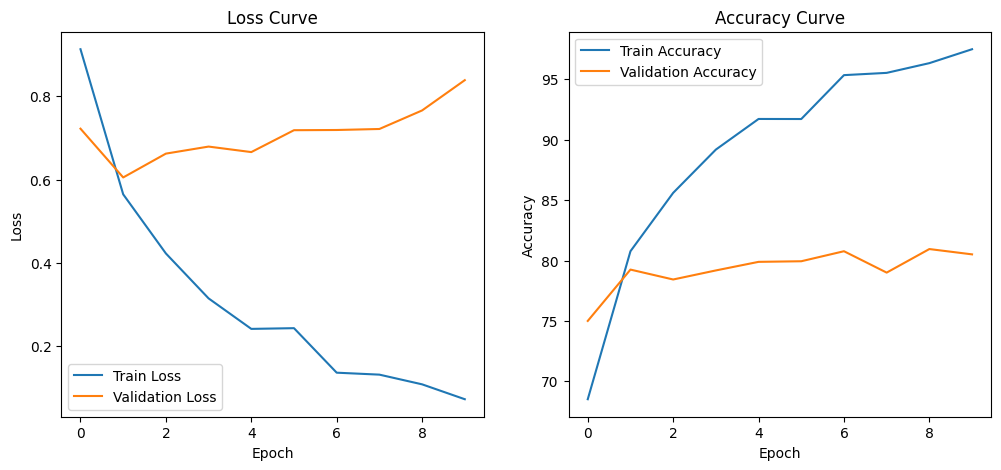

In [5]:
# Load the predefined ResNet-34 model and tune the output layer
class ResNet34Modified(nn.Module):
    def __init__(self):
        super(ResNet34Modified, self).__init__()
        self.model = resnet34(pretrained=True) 
        self.model.fc = nn.Linear(self.model.fc.in_features, 10)

    def forward(self, x):
        return self.model(x)

# data loader
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
valloader = DataLoader(valset, batch_size=128, shuffle=False)

# Models, Loss Functions and Optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet34Modified().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and validation with recording of losses and accuracies
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
for epoch in range(10):
    # train mode
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(100 * correct / total)

    # validation mode
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(valloader))
    val_accuracies.append(100 * correct / total)

    print(f'Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Train Acc={train_accuracies[-1]:.2f}%, '
          f'Val Loss={val_losses[-1]:.4f}, Val Acc={val_accuracies[-1]:.2f}%')

# Plotting loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()


Epoch 1: Train Loss=0.9230, Train Acc=68.51%, Val Loss=0.8444, Val Acc=71.40%
Epoch 2: Train Loss=0.5925, Train Acc=79.89%, Val Loss=0.7037, Val Acc=76.78%
Epoch 3: Train Loss=0.4438, Train Acc=84.65%, Val Loss=0.6445, Val Acc=78.37%
Epoch 4: Train Loss=0.3727, Train Acc=87.38%, Val Loss=0.6172, Val Acc=79.98%
Epoch 5: Train Loss=0.2637, Train Acc=90.94%, Val Loss=0.6869, Val Acc=79.35%
Epoch 6: Train Loss=0.1991, Train Acc=93.03%, Val Loss=0.6506, Val Acc=81.09%
Epoch 7: Train Loss=0.1573, Train Acc=94.62%, Val Loss=0.7265, Val Acc=80.04%
Epoch 8: Train Loss=0.1245, Train Acc=95.70%, Val Loss=0.7435, Val Acc=80.49%
Epoch 9: Train Loss=0.1122, Train Acc=96.21%, Val Loss=0.7707, Val Acc=80.47%
Epoch 10: Train Loss=0.0984, Train Acc=96.58%, Val Loss=0.8126, Val Acc=80.34%
Epoch 11: Train Loss=0.0896, Train Acc=96.89%, Val Loss=0.8746, Val Acc=78.96%
Epoch 12: Train Loss=0.0988, Train Acc=96.71%, Val Loss=0.8325, Val Acc=79.95%
Epoch 13: Train Loss=0.0615, Train Acc=97.92%, Val Loss=0.881

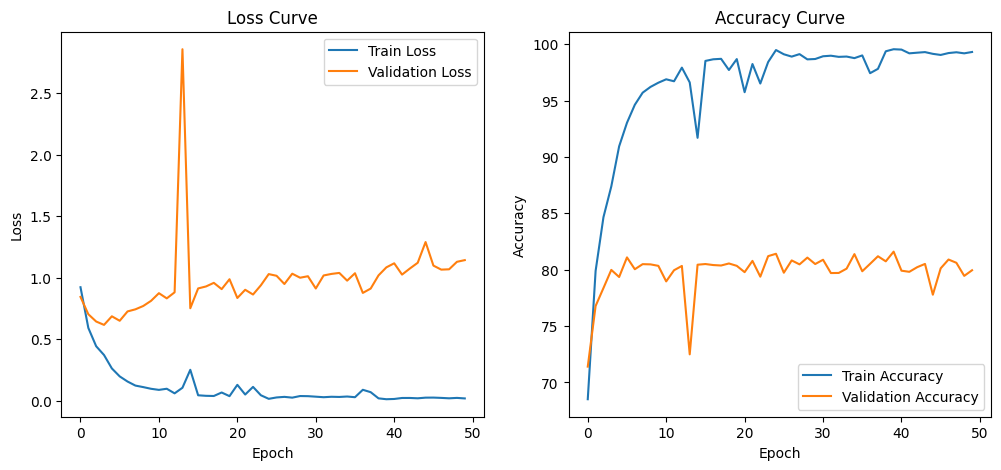

In [6]:
# Load the predefined ResNet-34 model and tune the output layer
class ResNet34Modified(nn.Module):
    def __init__(self):
        super(ResNet34Modified, self).__init__()
        self.model = resnet34(pretrained=True)  
        self.model.fc = nn.Linear(self.model.fc.in_features, 10)  

    def forward(self, x):
        return self.model(x)

# data loader
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)
valloader = DataLoader(valset, batch_size=100, shuffle=False)

# Models, Loss Functions and Optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet34Modified().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and validation with recording of losses and accuracies
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
for epoch in range(50):
    # train mode
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(100 * correct / total)

    # validation mode
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(valloader))
    val_accuracies.append(100 * correct / total)

    print(f'Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Train Acc={train_accuracies[-1]:.2f}%, '
          f'Val Loss={val_losses[-1]:.4f}, Val Acc={val_accuracies[-1]:.2f}%')

# Plotting loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train Loss=1.1524, Train Acc=61.46%, Val Loss=0.7958, Val Acc=73.07%
Epoch 2: Train Loss=0.8262, Train Acc=72.69%, Val Loss=0.7291, Val Acc=75.20%
Epoch 3: Train Loss=0.7024, Train Acc=76.51%, Val Loss=0.6700, Val Acc=77.01%
Epoch 4: Train Loss=0.6582, Train Acc=77.78%, Val Loss=0.6660, Val Acc=76.83%
Epoch 5: Train Loss=0.5871, Train Acc=80.31%, Val Loss=1.9699, Val Acc=44.38%
Epoch 6: Train Loss=0.7274, Train Acc=75.27%, Val Loss=0.6382, Val Acc=77.81%
Epoch 7: Train Loss=0.5452, Train Acc=81.40%, Val Loss=0.6185, Val Acc=78.37%
Epoch 8: Train Loss=0.4950, Train Acc=82.98%, Val Loss=0.5973, Val Acc=79.66%
Epoch 9: Train Loss=0.5700, Train Acc=81.17%, Val Loss=0.7137, Val Acc=76.36%
Epoch 10: Train Loss=0.5291, Train Acc=81.91%, Val Loss=0.7604, Val Acc=75.93%
Epoch 11: Train Loss=0.5448, Train Acc=82.11%, Val Loss=0.5800, Val Acc=80.40%
Epoch 12: Train Loss=0.4498, Train Acc=84.65%, Val Loss=0.5179, 

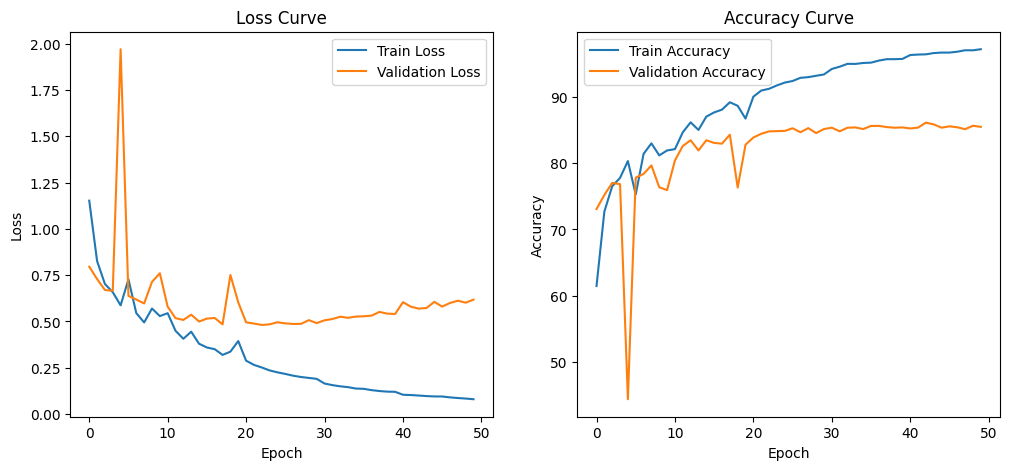

In [7]:
# Load the predefined ResNet-34 model and tune the output layer
class ResNet34Modified(nn.Module):
    def __init__(self):
        super(ResNet34Modified, self).__init__()
        self.model = resnet34(pretrained=True)
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5), 
            nn.Linear(self.model.fc.in_features, 10)
        )

    def forward(self, x):
        return self.model(x)

# data enhancement
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)


# Models, Loss Functions and Optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet34Modified().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Training and validation with recording of losses and accuracies
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
for epoch in range(50):
    # train mode
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(100 * correct / total)

    # Updated learning rate
    scheduler.step()

    # validation mode
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(valloader))
    val_accuracies.append(100 * correct / total)

    print(f'Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Train Acc={train_accuracies[-1]:.2f}%, '
          f'Val Loss={val_losses[-1]:.4f}, Val Acc={val_accuracies[-1]:.2f}%')

# Plotting loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()
